In [6]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_groq langchain_community

In [ ]:
from typing_extensions import TypedDict
from typing import List

class State(TypedDict):
    current_message: str
    history: List[str]

In [ ]:
import os
from langchain_groq import ChatGroq
from langchain_community.embeddings import HuggingFaceEmbeddings 
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser


GROQ_API_KEY = "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"


llm = ChatGroq(temperature=0.7, groq_api_key=GROQ_API_KEY, model_name="llama-3.1-8b-instant")


embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")


def initial_thought(state):
    print("---INITIAL THOUGHT---")
    
    current_message = state["current_message"]
    history = state.get("history", [])

    prompt = ChatPromptTemplate.from_messages([
        ("system", "You are a helpful assistant. Process the following input and generate a thoughtful initial response or observation."),
        ("user", "Input: {current_message}\nHistory: {history}\nInitial Thought:")
    ])
    chain = prompt | llm | StrOutputParser()
    thought = chain.invoke({"current_message": current_message, "history": history})
    
    
    new_history = history + [f"User Input: {current_message}", f"AI Initial Thought: {thought}"]
    return {"current_message": thought, "history": new_history}


def elaborate_response(state):
    print("---ELABORATING RESPONSE---")
    
    current_message = state["current_message"]
    history = state["history"]

    prompt = ChatPromptTemplate.from_messages([
        ("system", "You are a helpful assistant. Elaborate further on the following thought, expanding it into a more complete response."),
        ("user", "Thought: {current_message}\nHistory: {history}\nElaborated Response:")
    ])
    chain = prompt | llm | StrOutputParser()
    response = chain.invoke({"current_message": current_message, "history": history})
    
    
    new_history = history + [f"AI Elaborated: {response}"]
    return {"current_message": response, "history": new_history}


def finalize_output(state):
    print("---FINALIZING OUTPUT---")
    
    current_message = state["current_message"]
    history = state["history"]

    prompt = ChatPromptTemplate.from_messages([
        ("system", "You are a helpful assistant. Provide a concise final output based on the elaborated response."),
        ("user", "Elaborated Response: {current_message}\nHistory: {history}\nFinal Output:")
    ])
    chain = prompt | llm | StrOutputParser()
    final_output = chain.invoke({"current_message": current_message, "history": history})
    
    
    new_history = history + [f"AI Final Output: {final_output}"]
    return {"current_message": final_output, "history": new_history}

C:\Users\DELL\AppData\Local\Temp\ipykernel_19232\4162936161.py:15: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the `langchain-huggingface package and should be used instead. To use it run `pip install -U `langchain-huggingface` and import as `from `langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")


In [ ]:
from typing import Literal
import random

def decide_next_step(state) -> Literal["elaborate_response", "finalize_output"]:
    print("---DECIDING NEXT STEP---")
    

    if random.random() < 0.7: 
        print("---Deciding to elaborate further.---")
        return "elaborate_response"
    else:
        print("---Deciding to finalize the output.---")
        return "finalize_output"

---Graph Visualization---


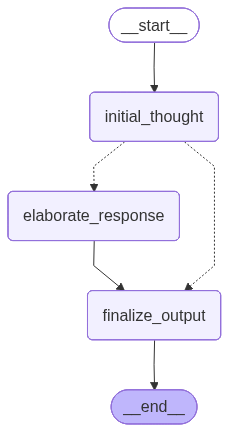

In [ ]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END


builder = StateGraph(State)
builder.add_node("initial_thought", initial_thought)
builder.add_node("elaborate_response", elaborate_response)
builder.add_node("finalize_output", finalize_output)


builder.add_edge(START, "initial_thought")
builder.add_conditional_edges("initial_thought", decide_next_step) 
builder.add_edge("elaborate_response", "finalize_output") 
builder.add_edge("finalize_output", END) 


graph = builder.compile()


print("---Graph Visualization---")
display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
print("---Invoking with first example---")
result1 = graph.invoke({"current_message": "Explain the concept of quantum entanglement.", "history": []})
print("\nFinal State for Example 1:")
for item in result1['history']:
    print(item)
print(f"\nFinal Message: {result1['current_message']}")


print("\n---Invoking with second example---")
result2 = graph.invoke({"current_message": "Tell me a short, imaginative story about a space-faring cat.", "history": []})
print("\nFinal State for Example 2:")
for item in result2['history']:
    print(item)
print(f"\nFinal Message: {result2['current_message']}")


print("\n---Invoking with third example---")
result3 = graph.invoke({"current_message": "What are the benefits of a healthy diet?", "history": []})
print("\nFinal State for Example 3:")
for item in result3['history']:
    print(item)
print(f"\nFinal Message: {result3['current_message']}")

---Invoking with first example---
---INITIAL THOUGHT---
---DECIDING NEXT STEP---
---Deciding to elaborate further.---
---ELABORATING RESPONSE---
---FINALIZING OUTPUT---

Final State for Example 1:
User Input: Explain the concept of quantum entanglement.
AI Initial Thought: Quantum entanglement is a fascinating concept in the realm of quantum mechanics that has left scientists and philosophers alike scratching their heads for decades. At its core, entanglement refers to a phenomenon where two or more particles become correlated in such a way that the state of one particle is dependent on the state of the others, regardless of the distance between them.

Imagine two connected dancers, where the movement of one dancer is instantly reflected in the movement of the other, even if they are separated by vast distances. This is roughly the idea behind entanglement, where the properties of entangled particles, such as spin, momentum, or energy, become linked in a way that transcends classical n